In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import warnings; warnings.simplefilter('ignore')
import fitsio

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import get_sweep_patch, cut, cut_sweeps, get_random_patch, get_area, flux_to_mag
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func, get_GM_stats, get_PM_stats, sky_PM
from photometric_def import get_stars, get_galaxies, get_photo_stats, plot_venn3, flow_1, flow_2


# GEOMETRICAL

## Data reduction

### SWEEP subsample

The SWEEP files from DECaLS DR7 are stored on:

    /global/project/projectdirs/cosmo/data/legacysurvey/dr7/sweep/7.1

Below we have an example on how to extract data from the SWEEP files. The function that extrac the data is called `get_sweep_patch` and requires the sky coordinates of a rectangle/square in format `[RAmin, RAmax, DECmin, DECmax]` and magnitude limit in the r-band with extinction correction. 

For this analysis we don't use the whole data, instead we focus on a big patch of the sky with coordinates:

        160 < RA < 230
        -2 < DEC < 18.

We have choosen this patch because it represents one of the most completenes region of the Legacy Survey and other surveys like...EXAMPLES OF OTHER SURVEYS WITHIN THIS FOOTPRINT...
The code below shows an example of how to extract the objects from the sweeps and to make things faster I am cutting off in total magnitude at 20. The whole process only took $111.49$ sec and the size of the catalogue created is $3.11$ GB with a total of $5455184$ objects.

The `get_sweep_patch` function can be called usging the following comand:

    sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
    from main_def import get_sweep_patch

The first line contain the path where the main functions are stored and the second line call the needed function `get_sweep_patch` to extract the data from the SWEEPS. The `get_sweep_patch` function is located at main definitions file:

    /global/homes/q/qmxp55/DESI/BGS_paper/main_def.py
    
`df` is the subsample catalogue which was also stored at this notebook path

    /global/project/projectdirs/desi/users/qmxp55/BGS_paper/[sweep_subsample].npy
    
The catalogue was stored with numpy format `.npy` which is faster to write and read than `.fits`. 

The `get_sweep_patch` won't create duplicates for same patches in the sky neither will extract the data again if file is already there and instead this will load the catalogue.

If needed numpy data frames (`.npy`) can be read just typing:

    df = np.load('[sweep_subsample].npy')
    

In [2]:
!ls /global/cscratch1/sd/adamyers/dr8c-custom-sweeps/decam/sweep

sweep-130p030-140p035.fits  sweep-140p030-150p035.fits
sweep-130p035-140p040.fits


In [3]:
#define the square/rectangle patch of the sky in format [RAmin, RAmax, DECmin, DECmax]
#main_patch = [160, 230, -2, 18]
#main_patch = [180, 200, 5, 15]
#main_patch = [195, 200, 5, 10]
main_patch = [134, 139, 32, 34]
#main_patch = [160, 190, 30, 33]

rlimit = 20
N = 2
dr = 'dr8c'
v = 'v3.0'
    
ramin, ramax, decmin, decmax = main_patch[0], main_patch[1], main_patch[2], main_patch[3]
dir_name = '%s_%s_%s_%s_%s_%s_rmag_%s_N_%s' %(dr, v, str(ramin), str(ramax), str(decmin), 
                                                 str(decmax), str(20), str(N))
dir_ = os.path.isdir(dir_name)

if dir_:
    print('The directory with %i < RA < %i, %i < DEC < %i, rmag limit=%2.2g and N=%i already exist...' 
          %(ramin, ramax, decmin, decmax, rlimit, N))
else:
    os.system('mkdir %s' %(dir_name))

#get subsample catalogue
df = get_sweep_patch(patch=main_patch, rlimit=rlimit, dr=dr)

#give the right permissions to share the subsample catalogue
#!chmod 777 *.npy

The directory with 134 < RA < 139, 32 < DEC < 34, rmag limit=20 and N=2 already exist...
sweep file already exist at:/global/project/projectdirs/desi/users/qmxp55/BGS_paper/dr8c_sweep_134_139_32_34_rmag_20.npy
Total run time: 0.000752 sec
Area of 134 < RA < 139 & 32 < DEC < 34: 8.386 deg^2
Weight of dr8c_sweep_134_139_32_34_rmag_20.npy catalogue: 15.32 MB


### RANDOMS

To get the densities we are going to made use of the randoms created by the target selection team. Currently there's one random catalogue for each version of the `desitarget` pipeline and the last version that include the randoms is `0.29.0` but for some reason there's a problem in `MASKBITS` parameters that is why here we're going to take the last stable version (`0.22.0`) for DR7 stored here:

    /global/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/
  
The randoms are splitted into $10$ different `.fits` files covering very high densities. We don't require such that big densitites at this point and $\sim 5$ times more randoms than objects will be fine.

To select the randoms we use the function `get_random_patch` which is similar as the `get_sweep_patch` function and will extract the randoms from a patch coordinates of the form `[RAmin, RAmax, DECmin, DECmax]`. The `N` variable means how many of the randoms files available we want,for the patch we're working on `160 < RA < 230` and `-2 < DEC < 18` we require `N=3` to get $7.6$ times more randoms than objects within the patch. Last we have `sweepsize` that is just the size of the sweep catalogue to get the fraction of randoms over the seweeps. 

The whole process of extract the randoms takes only $\sim 30$ seconds for `N=3` and the choosen patch.

    *How many times bigger in the number of objects in the catalogue do we want for the randoms?
    *Shall we make a cut off as footprint patch?

In [4]:
df_ran = get_random_patch(patch=main_patch, N=N, sweepsize=len(df), dr=dr)

RANDOM file already exist at:/global/project/projectdirs/desi/users/qmxp55/BGS_paper/dr8c_random_134_139_32_34_N_2.npy
Total run time: 0.000873 sec
Area of 134 < RA < 139 & 32 < DEC < 34: 8.386 deg^2
Weight of dr8c_random_134_139_32_34_N_2.npy catalogue: 19.17 MB


## Start up point

In [5]:
A = get_area(patch=main_patch, get_val=True)
rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
bright = rmag < 19.5
faint = rmag > 19.5

main_bright = np.sum(bright)/A
main_faint = np.sum(faint)/A

print('-------- Start up point --------')
print('AREA: %2.4g [sq.deg]' %(A))
print('Density Bright: %2.5g [1/sq.deg]' %(main_bright))
print('Density Faint: %2.5g [1/sq.deg]' %(main_faint))

Area of 134 < RA < 139 & 32 < DEC < 34: 8.386 deg^2
-------- Start up point --------
AREA: 8.386 [sq.deg]
Density Bright: 2669.8 [1/sq.deg]
Density Faint: 931.28 [1/sq.deg]


## Geometric Masking (GM)

### Bright Star, Galaxies and Clusters masking: SWEEPS and RANDOMS

In [6]:
BS = (np.uint64(df['MASKBITS']) & np.uint64(2**1))!=0
MS = (np.uint64(df['MASKBITS']) & np.uint64(2**11))!=0
GC = (np.uint64(df['MASKBITS']) & np.uint64(2**13))!=0
LG = (np.uint64(df['MASKBITS']) & np.uint64(2**12))!=0
#BM = (BM_bright) | (BM_medium) | (BM_cluster) | (BM_galaxy)

BS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**1))!=0
MS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**11))!=0
GC_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**13))!=0
LG_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**12))!=0

### Geometric Mask (GM) results

Results for the `GEOMETRICAL` part are given in three quantities, the `fraction of area` in percentage masked by each mask out of the total area ($f_{A}$) and the `densities` in square degrees in the `bright (B)` and `faint (F)` part ($\eta_{B}$, $\eta_{F}$),

$$f_{A}(i) = \frac{N_{R}(i)}{N_{R}}\times 100 [\%]$$
$$\eta_{B}(i)^* = N(i,B)/A$$
$$\eta_{B}(i) = N(i,B)/A(i)$$
where,
$$A(i) = \frac{N_{R}(i)}{N_{R}}A$$ 
and
$$i \equiv \{stars, LG, allmask, nobs, \sim(STARS | LG), \sim(STARS | LG | ALLMASK | NOBS), etc ...\}$$

The $^*$ means the density has not correction for the masked area.

In [11]:
GA = df['REF_CAT'] == 'G2'
print(np.sum(GA))

19998


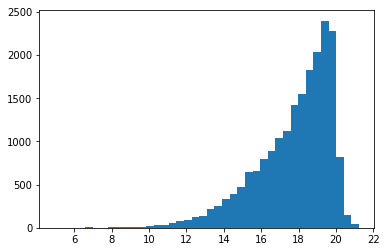

In [13]:
plt.hist(df['GAIA_PHOT_G_MEAN_MAG'][GA], 40)
plt.show()

In [7]:
GM = {'BS':BS, 'MS':MS, 'GC':GC, 'LG':LG}
GM_ran = {'BS_ran':BS_ran, 'MS_ran':MS_ran, 'GC_ran':GC_ran, 'LG_ran':LG_ran}

In [8]:
def get_GM_stats(mask, mask_ran, A, B, F):
    
    from astropy.table import Table
    Tab = []
    GMT = np.zeros(len(mask[list(mask)[0]]), dtype='?')
    GMT_ran = np.zeros(len(mask_ran[list(mask_ran)[0]]), dtype='?')
    j = 0
    #row_names = ['STARS', 'LG', '(STARS | LG)','~(STARS | LG)*', '~(STARS | LG)']
    
    for i in mask:
        
        A_i = (np.sum(mask_ran[i+'_ran'])/len(mask_ran[i+'_ran']))*(A)
        eta_B_i_in = np.sum((mask[i] & (B)))/(A_i) #density over the geometric area
        eta_F_i_in = np.sum((mask[i] & (F)))/(A_i) #density over the geometric area
        eta_B_i = np.sum((mask[i] & (B)))/(A) #density over the total area
        eta_F_i = np.sum((mask[i] & (F)))/(A) #density over the total area
        
        Tab.append([i, A_i*(100/A), eta_B_i, eta_F_i])
    
        if j is 0:
            lab = i
            j += 1
            continue
        lab = '%s | %s' %(lab, i)
        GMT |= mask[i]
        GMT_ran |= mask_ran[i+'_ran']
        j += 1
    
    lab_in = '(%s)' %(lab)
    lab_out = '~(%s)*' %(lab)
    lab_out2 = '~(%s)' %(lab)
    
    A_GMT_in = (np.sum(GMT_ran)/len(GMT_ran))*(A)
    eta_B_GMT_in_1 = np.sum((GMT) & (B))/(A) #Not corrected for mask area
    eta_F_GMT_in_1 = np.sum((GMT) & (F))/(A) #Not corrected for mask area

    A_GMT_out = (np.sum(~GMT_ran)/len(GMT_ran))*(A)
    eta_B_GMT_out_1 = np.sum((~GMT) & (B))/(A) #Not corrected for mask area
    eta_B_GMT_out_2 = np.sum((~GMT) & (B))/(A_GMT_out) #Corrected for mask area
    eta_F_GMT_out_1 = np.sum((~GMT) & (F))/(A) #Not corrected for mask area
    eta_F_GMT_out_2 = np.sum((~GMT) & (F))/(A_GMT_out) #Corrected for mask area
    
    Tab.append([lab_in, A_GMT_in*(100/A), eta_B_GMT_in_1, eta_F_GMT_in_1])
    Tab.append([lab_out, A_GMT_out*(100/A), eta_B_GMT_out_1, eta_F_GMT_out_1])
    Tab.append([lab_out2, A_GMT_out*(100/A), eta_B_GMT_out_2, eta_F_GMT_out_2])
    
    Tab = np.transpose(Tab)
    t = Table([Tab[0], Tab[1], Tab[2], Tab[3]], 
              names=('GM','$f_{A}$ [$\%$]', '$\eta_{B}$ [deg$^2$]', '$\eta_{F}$ [deg$^2$]'),
                    dtype=('S', 'f8', 'f8', 'f8'))
                                    
    return t, GMT, GMT_ran


In [ ]:
if PrevMask is not None:
    for i in PrevMask:
        

In [9]:
tGM, GMT, GMT_ran = get_GM_stats(mask=GM, mask_ran=GM_ran, A=A, B=bright, F=faint)
tGM

GM,$f_{A}$ [$\%$],$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$]
bytes21,float64,float64,float64
BS,3.219157552069339,153.82267416791018,23.252264699800378
MS,4.646563799792928,559.1275342428921,40.54241024580579
GC,0.0,0.0,0.0
LG,0.0675907250239732,24.086961381331673,1.3116662138348931
(BS | MS | GC | LG),4.713557433606442,582.6182837088444,41.85407645964068
~(BS | MS | GC | LG)*,95.28644256639356,2087.2186733605427,889.4289353631334
~(BS | MS | GC | LG),95.28644256639356,2190.467622827049,933.4265310024543


In [10]:
def plot_venn3(mask, mask2, mask2_ran, A, B, F, row_names, filename=None):  
    sf = 2
    M = [B,F]
    
    if mask2_ran is not None:
        A_G_out = (np.sum(~mask2_ran)/len(mask2_ran))*(A)
    else:
        A_G_out = A
        
    for i in range(len(M)):
        if mask2 is not None:
            A1 = (mask[0]) & (~mask2) & (M[i])
            B1 = (mask[1]) & (~mask2) & (M[i])
            C1 = (mask[2]) & (~mask2) & (M[i])
        else:
            A1 = (mask[0]) & (M[i])
            B1 = (mask[1]) & (M[i])
            C1 = (mask[2]) & (M[i])
        AB = (A1) & (B1)
        AC = (A1) & (C1)
        BC = (B1) & (C1)
        ABC = (A1) & (B1) & (C1)
            
        a1 = round((np.sum(A1) - np.sum(AB) - np.sum(AC) + np.sum(ABC))/A_G_out, sf)
        a2 = round((np.sum(B1) - np.sum(AB) - np.sum(BC) + np.sum(ABC))/A_G_out, sf)
        a3 = round((np.sum(AB) - np.sum(ABC))/A_G_out, sf)
        a4 = round((np.sum(C1) - np.sum(AC) - np.sum(BC) + np.sum(ABC))/A_G_out, sf)
        a5 = round((np.sum(AC) - np.sum(ABC))/A_G_out, sf)
        a6 = round((np.sum(BC) - np.sum(ABC))/A_G_out, sf)
        a7 = round(np.sum(ABC)/A_G_out, sf)

        if i == 0:
            Mi = 'B'
        else:
            Mi = 'F'
            
        from matplotlib_venn import venn3
        plt.figure(figsize=(5, 5))
        
        venn3([a1, a2, a3, a4, a5, a6, a7], 
                  set_labels = (row_names[0]+'_%s' %(Mi), row_names[1]+'_%s' %(Mi), row_names[2]+'_%s' %(Mi)))
        if filename is not None:
                plt.savefig(filename + '_' + Mi + '.png')

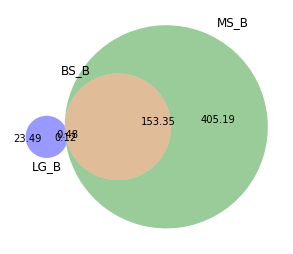

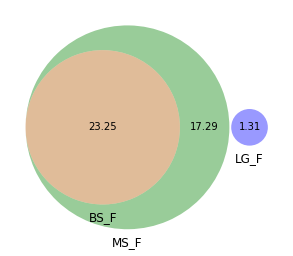

In [11]:
plot_venn3(mask=[BS, MS, LG], mask2=None, mask2_ran=None, A=A, B=bright, F=faint, row_names = ['BS', 'MS', 'LG'], 
                                filename='%s/venn_GM' %(dir_name))

## Pixel Masking (PM)

### ALLMASK Mask: SWEEPS and RANDOMS

5 	ALLMASK_G 	touches a pixel that has any of the ALLMASK_G bits set
6 	ALLMASK_R 	touches a pixel that has any of the ALLMASK_R bits set
7 	ALLMASK_Z 	touches a pixel that has any of the ALLMASK_Z bits set

In [12]:
#allmask = (df['ALLMASK_R'] != 0) | (df['ALLMASK_G'] != 0) | (df['ALLMASK_Z'] != 0)
allmask = ((df['MASKBITS'] & 2**6) != 0) | ((df['MASKBITS'] & 2**5) != 0) | ((df['MASKBITS'] & 2**7) != 0)
#print(np.sum(allmask), np.sum(allmask2))
allmask_ran = ((df_ran['MASKBITS'] & 2**6) != 0) | ((df_ran['MASKBITS'] & 2**5) != 0) | ((df_ran['MASKBITS'] & 2**7) != 0)

### NOBS Mask: SWEEPS and RANDOMS

In [13]:
nobs = (df['NOBS_G'] < 1) | (df['NOBS_R'] < 1) | (df['NOBS_Z'] < 1)

nobs_ran = (df_ran['NOBS_G'] < 1) | (df_ran['NOBS_R'] < 1) | (df_ran['NOBS_Z'] < 1)

### Pixexl Mask (PM) results

In [14]:
PM = [allmask, nobs]
PM_ran = [allmask_ran, nobs_ran]

PM,$f_{A}$ [$\%$],$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$]
bytes31,float64,float64,float64
ALLMASK,0.3423721000772636,18.840296525992102,7.750754899933459
NOBS,0.37425677071578106,9.53939064607195,5.842876770719069
(ALLMASK | NOBS),0.37425677071578106,18.840296525992102,7.750754899933459
~(STARS | LG | ALLMASK | NOBS)*,94.91218579567776,2068.3783768345506,881.6781804632
~(STARS | LG | ALLMASK | NOBS),94.91218579567776,2179.2548127458076,928.9409711427708


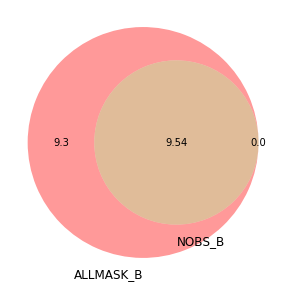

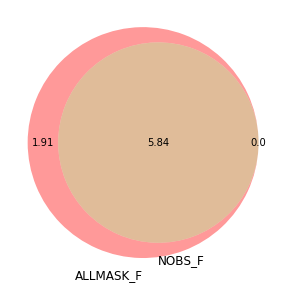

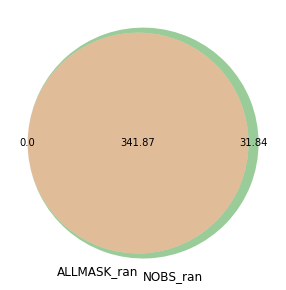

In [15]:
tPM = get_PM_stats(mask=PM, mask_ran=PM_ran, mask2=GMT, 
                   mask2_ran=GMT_ran, A=A, B=bright, F=faint, venn=True, 
                   filename='%s/venn_PM' %(dir_name))

tPM

ALLMASK=223
NOBS=129
ALLMASK ran=2867
NOBS ran=3134


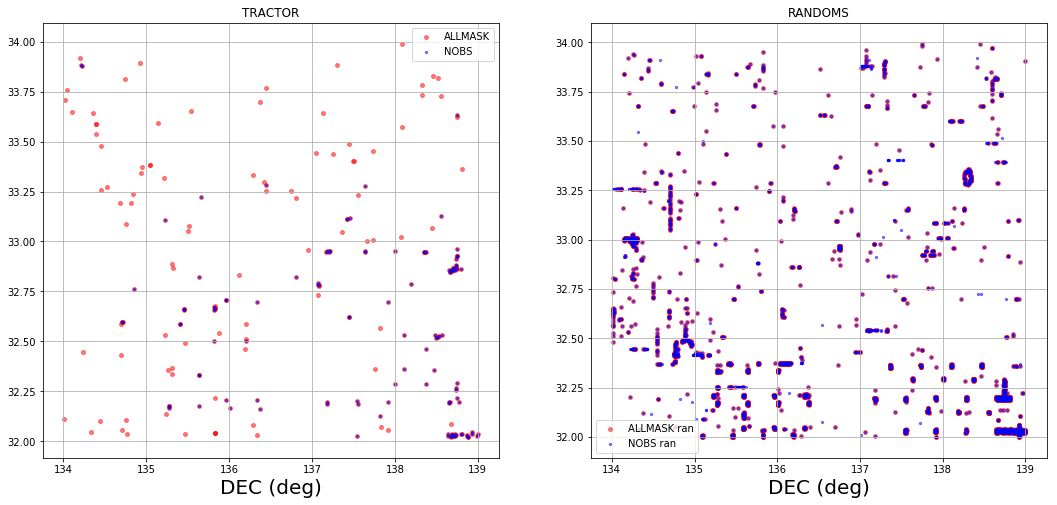

ALLMASK=7
NOBS=6
ALLMASK ran=5
NOBS ran=5


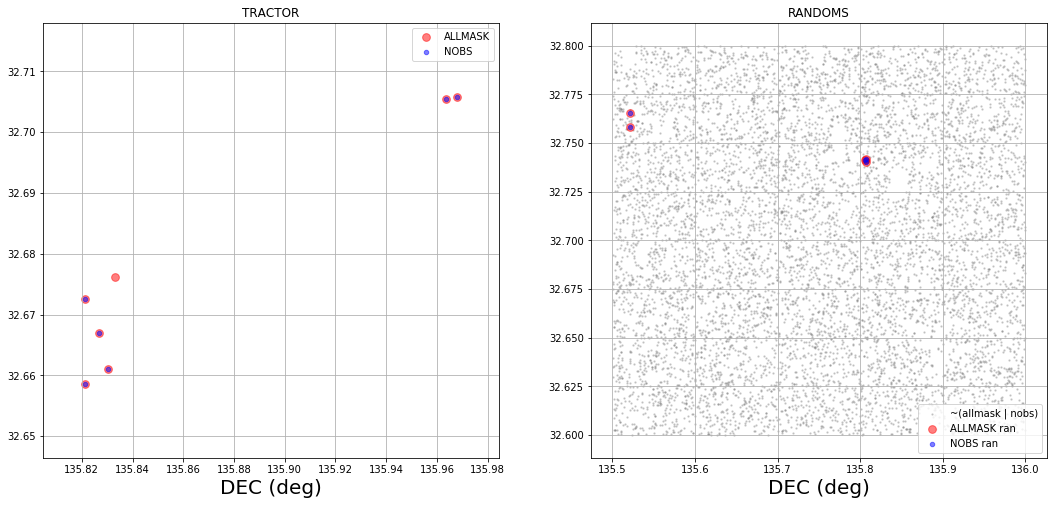

In [16]:
sky_PM(coord=[df['RA'], df['DEC']],coord_ran=[df_ran['RA'], df_ran['DEC']], mask=PM, mask_ran=PM_ran, mask2=GMT, 
                   mask2_ran=GMT_ran, lim=None, filename='%s/sky_PM' %(dir_name))

dist_ra, dist_dec = ramax - ramin, decmax - decmin
dra, ddec = dist_ra/10, dist_dec/10

sky_PM(coord=[df['RA'], df['DEC']],coord_ran=[df_ran['RA'], df_ran['DEC']], mask=PM, mask_ran=PM_ran, mask2=GMT, 
                   mask2_ran=GMT_ran, lim=[ramin+3*dra,ramin+4*dra,decmin+3*ddec,decmin+4*ddec], 
                       filename='%s/sky_PM_zoom' %(dir_name))


## Overall GEOMETRICAL mask: SWEEPS and RANDOMS

In [17]:
GEO_veto = (GMT) | (PM[0]) | (PM[1])
GEO_ran_veto = (GMT_ran) | (PM_ran[0]) | (PM_ran[1])

# PHOTOMETRY

## Star-Galaxy separation (SG)

### STARS selection: SWEEPS

In [18]:
STARS = get_stars(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'])

### GALAXY selection: SWEEPS

In [19]:
GAL = get_galaxies(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'])

### Star-Galaxy separation (SG) results

In [20]:
tSG = get_photo_stats(mask=[STARS], mask2=GEO_veto, mask2_ran=GEO_ran_veto, 
                   A=A, B=bright, F=faint, row_names = ['STARS', 'GALAXIES'])

#tSG

## Fibre Magnitude Cut (FMC)

In [21]:
fibmag = flux_to_mag(df['FIBERFLUX_R']/df['MW_TRANSMISSION_R'])

FMC = fibmag < 2.9 + 1.0*rmag

### Fiber Magnitude Cut results

In [22]:
tFMC = get_photo_stats(mask=[~FMC], mask2=((GEO_veto) | (STARS)), mask2_ran=GEO_ran_veto, 
                   A=A, B=bright, F=faint, row_names = ['fibmag > 2.9+rmag', 'fibmag < 2.9+rmag'])

#tFMC

## Colour Cut (CC)

In [23]:
CC = ((gmag - rmag) > -1) & ((gmag - rmag) < 4) & ((rmag - zmag) > -1) & ((rmag - zmag) < 4)

### Colour Cut results

In [ ]:
tCC = get_photo_stats(mask=[~CC], mask2=((GEO_veto) | (STARS) | (~FMC)), mask2_ran=GEO_ran_veto, 
                   A=A, B=bright, F=faint, row_names = ['(-1 < (g-r) < 4) & (-1 < (r-z) < 4)', 
                                                        '~(-1 < (g-r) < 4) | ~(-1 < (r-z) < 4)'])

#tCC

## Quality Cuts (QC)

In [ ]:
QC_FM = (df['FRACMASKED_R'] < 0.4) & (df['FRACMASKED_G'] < 0.4) & (df['FRACMASKED_Z'] < 0.4)
QC_FI = (df['FRACIN_R'] > 0.3) & (df['FRACIN_G'] > 0.3) & (df['FRACIN_Z'] > 0.3)
QC_FF = (df['FRACFLUX_R'] < 5.0) & (df['FRACFLUX_G'] < 5.0) & (df['FRACFLUX_Z'] < 5.0)
QC_IVAR = (df['FLUX_IVAR_R'] > 0) & (df['FLUX_IVAR_G'] > 0) & (df['FLUX_IVAR_Z'] > 0)

#All QC's together...
QC = (QC_FM) & (QC_FI) & (QC_FF) & (QC_IVAR)

### Quality Cuts results

In [ ]:
tQC_FM = get_photo_stats(mask=[~QC_FM], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['fracmasked_{G,R,Z} > 0.4', 'fracmasked_{G,R,Z} < 0.4'])

#tQC_FM

In [ ]:
tQC_FI = get_photo_stats(mask=[~QC_FI], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['fracin_{G,R,Z} < 0.3', 'fracin_{G,R,Z} > 0.3'])

#tQC_FI

In [ ]:
tQC_FF = get_photo_stats(mask=[~QC_FF], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['fracflux_{G,R,Z} > 5.0', 'fracflux_{G,R,Z} < 5.0'])

#tQC_FF

In [ ]:
tQC_IVAR = get_photo_stats(mask=[~QC_IVAR], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['flux_ivar_{G,R,Z} = 0', 'flux_ivar_{G,R,Z} > 0'])

tQC_IVAR

PHOTOMETRY,$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$]
bytes21,float64,float64
"flux_ivar_{G,R,Z} = 0",0.0,0.0
"flux_ivar_{G,R,Z} > 0",726.7951742035337,532.564346317853


In [ ]:
#All together...
tQC_all = get_photo_stats(mask=[~QC], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['~ALL_QC', 'ALL_QC'])

#tQC_all

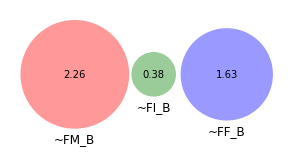

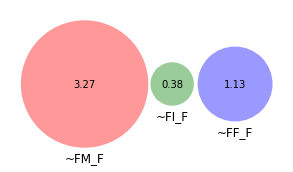

In [ ]:
tQC = get_photo_stats(mask=[~QC_FM, ~QC_FI, ~QC_FF, ~QC_IVAR], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                         row_names = ['~FM', '~FI', '~FF', '~IVAR', 'ALL_QC'])


plot_venn3(mask=[~QC_FM, ~QC_FI, ~QC_FF, ~QC_IVAR], mask2=((GEO_veto) | (STARS) | (~FMC) | (~CC)), 
                         mask2_ran=GEO_ran_veto, A=A, B=bright, F=faint, 
                             row_names = ['~FM', '~FI', '~FF', '~IVAR', 'ALL_QC'], 
                                filename='%s/venn_QC' %(dir_name))

#tQC

# PLOTS

# FLOW CHARTS...


In [8]:
import pygraphviz as pgv
from PIL import Image

def flow_1(file, tGM, tPM, area, main_bright, main_faint, patch):

    SU = 'START UP'
    SG = 'GEOMTRICAL'

    I = masking(title='DECaLS DR7', submasks=['rmag < 20', '%i < RA < %i' %(patch[0], patch[1]), 
                                              '%i < DEC < %i' %(patch[2], patch[3])], details=None)
    IGM = masking(title='Geometric Masking', submasks=['Bright Stars (BS)', 'Medium Stars (MS)', 'Globular Clusters (GC)', 
                                            'Large Galaxies (LG)'], details=['circular', 'circular', 'circular', 'elliptical'])
    IPM = masking(title='Pixel Masking', submasks=['ALLMASK', 'NOBS'], 
            details=['allmask_{G,R,Z} = 0', 'nobs_{G,R,Z} > 0'])

    #RESULTS...
    RI = results(a=area, b=main_bright, f=main_faint, stage='ini', per=False)
    RGM = results(a=tGM[5][1], b=tGM[5][2], f=tGM[5][3], b2=tGM[6][2], f2=tGM[6][3], stage='geo', per=True)
    RPM = results(a=tPM[3][1], b=tPM[3][2], f=tPM[3][3], b2=tPM[4][2], f2=tPM[4][3], stage='geo', per=True)
    #REJECTED by GM...
    RBS = results(a=tGM[0][1], b=tGM[0][2], f=tGM[0][3], stage='ini', per=True, title='Bright Stars')
    RMS = results(a=tGM[1][1], b=tGM[1][2], f=tGM[1][3], stage='ini', per=True, title='Medium Stars')
    RGC = results(a=tGM[2][1], b=tGM[2][2], f=tGM[2][3], stage='ini', per=True, title='Globular Cluster')
    RLG = results(a=tGM[3][1], b=tGM[3][2], f=tGM[3][3], stage='ini', per=True, title='Large Galaxies')
    RGMR = results(a=tGM[4][1], b=tGM[4][2], f=tGM[4][3], stage='ini', per=True, title='(BS) or (MS) or (GC) or (LG)')
    #REJECTED by PM...
    RAM = results(a=tPM[0][1], b=tPM[0][2], f=tPM[0][3], stage='ini', per=True, title='ALLMASK')
    RNOBS = results(a=tPM[1][1], b=tPM[1][2], f=tPM[1][3], stage='ini', per=True, title='NOBS')
    RPMR = results(a=tPM[2][1], b=tPM[2][2], f=tPM[2][3], stage='ini', per=True, title='(allmask) or (nobs)')

    G=pgv.AGraph(strict=False,directed=True)
    #G.graph_attr['label']="miles_dat"

    elist=[(SU,I), (I,RI),(RI,SG),(SG,IGM),(IGM,RGM),(IGM,RGMR),(RGMR,RBS),(RGMR,RMS),(RGMR,RGC),(RGMR, RLG),(RGM,IPM), (IPM, RPM),
          (IPM, RPMR), (RPMR, RAM), (RPMR, RNOBS)]
    G.add_edges_from(elist)

    nlist=[RI, RGM, RPM]
    G.add_nodes_from(nlist, color='deepskyblue', shape='box', style='filled')

    rejects=[RBS, RMS, RGC, RLG, RGMR, RAM, RNOBS, RPMR]
    G.add_nodes_from(rejects, color='coral', shape='box', style='filled')

    stages=[SU, SG]
    G.add_nodes_from(stages, color='green', style='filled')

    maskings=[I, IGM, IPM]
    G.add_nodes_from(maskings, color='gold', style='filled')

    G.write('%s.dot' %(file)) # write to simple.dot
    BB=pgv.AGraph('%s.dot' %(file)) # create a new graph from file
    BB.layout(prog='dot') # layout with default (neato)
    BB.draw('%s.ps' %(file)) # draw png

    os.system('convert ' + file + '.ps ' + file + '.png')

    flow = Image.open('%s.png' %(file))
    
    return flow


def flow_2(file, tPM, tSG, tFMC, tCC, tQC, tQC_all, area):

    SP = 'PHOTOMETRY'

    ISG = masking(title='Star-Galaxy Separation', submasks=['Galaxies'], details=['(G-rr > 0.6) or (G=0)'])
    IFMC = masking(title='Fibre Magnitude Cut (FMC)', submasks=None, details=['fibmag < rmag + 2.9'])
    ICC = masking(title='Colour Cuts', submasks=None, details=['-1 < g-r < 4', '-1 < r-z < 4'])
    IQC = masking(title='Quality Cuts', submasks=['FRACMASKED (FM)', 'FRACIN (FI)', 'FRACFLUX (FF)', 'FLUXIVAR'], 
                  details=['fracmasked_{G,R,Z}<0.4', 'fracin_{G,R,Z}>0.3', 'fracflux_{G,R,Z}<5', 'flux_ivar_{G,R,Z}>0'])

    #RESULTS...
    RI = results(a=tPM[4][1]*(area/100), b=tPM[4][2], f=tPM[4][3], stage='ini', per=False)
    RSG = results(b=tSG[1][1], f=tSG[1][2], stage='photo', per=True)
    RFMC = results(b=tFMC[1][1], f=tFMC[1][2], stage='photo', per=True)
    RCC = results(b=tCC[1][1], f=tCC[1][2], stage='photo', per=True)
    RQC = results(b=tQC[4][1], f=tQC[4][2], stage='photo', per=True)
    #REJECTED by SG...
    RSGR = results(b=tSG[0][1], f=tSG[0][2], stage='photo', per=True, title='STARS')
    #REJECTED by FM...
    RFMCR = results(b=tFMC[0][1], f=tFMC[0][2], stage='photo', per=True, title='FMC')
    #REJECTED by CC...
    RCCR = results(b=tCC[0][1], f=tCC[0][2], stage='photo', per=True, title='Colour Cuts')
    #REJECTED by QC...
    RFM = results(b=tQC[0][1], f=tQC[0][2], stage='photo', per=True, title='FRACMASKED')
    RFI = results(b=tQC[1][1], f=tQC[1][2], stage='photo', per=True, title='FRACIN')
    RFF = results(b=tQC[2][1], f=tQC[2][2], stage='photo', per=True, title='FRACFLUX')
    RIVAR = results(b=tQC[3][1], f=tQC[3][2], stage='photo', per=True, title='FLUXIVAR')
    RQCR = results(b=tQC_all[0][1], f=tQC_all[0][2], stage='photo', per=True, title='(FM) or (FI) or (FF)')

    G=pgv.AGraph(strict=False,directed=True)

    elist=[(RI, SP), (SP, ISG), (ISG, RSG), (ISG, RSGR), (RSG, IFMC), (IFMC, RFMC), (IFMC, RFMCR), (RFMC, ICC),
               (ICC, RCC), (ICC, RCCR), (RCC, IQC), (IQC, RQC), (IQC, RQCR), (RQCR, RFM), (RQCR, RFI),
                   (RQCR, RFF), (IQC, RIVAR)]
    G.add_edges_from(elist)

    nlist=[RI, RSG, RFMC, RCC, RQC]
    G.add_nodes_from(nlist, color='deepskyblue', shape='box', style='filled')

    rejects=[RSGR, RFMCR, RCCR, RFM, RFI, RFF, RIVAR, RQCR]
    G.add_nodes_from(rejects, color='coral', shape='box', style='filled')

    stages=[SP]
    G.add_nodes_from(stages, color='green', style='filled')

    maskings=[ISG, IFMC, ICC, IQC]
    G.add_nodes_from(maskings, color='gold', style='filled')

    G.write('%s.dot' %(file)) # write to simple.dot
    BB=pgv.AGraph('%s.dot' %(file)) # create a new graph from file
    BB.layout(prog='dot') # layout with default (neato)
    BB.draw('%s.ps' %(file)) # draw png

    os.system('convert ' + file + '.ps ' + file + '.png')

    flow = Image.open('%s.png' %(file))
    
    return flow

def masking(title, submasks, details):
    
    R = '%s \n\n' %(title)
    if submasks is not None:
        N = len(submasks)
    if details is not None:
        N = len(details)
        
    for i in range(N):
        if details and submasks is not None:
            if i<len(submasks)-1:
                R +='%i) %s \n %s \n' %(i+1, submasks[i], details[i])
            else:
                R +='%i) %s \n %s' %(i+1, submasks[i], details[i])
        else:
            if submasks is not None:
                if i<len(submasks)-1:
                    R +='%i) %s \n' %(i+1, submasks[i])
                else:
                    R +='%i) %s' %(i+1, submasks[i])
            if details is not None:
                if i<len(details)-1:
                    R +='%i) %s \n' %(i+1, details[i])
                else:
                    R +='%i) %s' %(i+1, details[i])
    
    return [R]

def results(a=None, b=None, f=None, b2=None, f2=None, stage='geo', per=True, title=None):
    boldblack = ''#'\033[0;30;1m'
    normal = ''#'\033[0;30;0m'
    gray = ''#'\033[0;30;37m'
    
    if per:
        n = '%'
    else:
        n = 'sq.d'
    
    if stage=='geo':
        R1 = '%s Area: %s%.2f (%s) \n' %(boldblack, normal, a, n)
        R2 = '%s Bright*: %s%.2f (1/sq.d) \n' %(boldblack, normal, b)
        R3 = '%s Faint*: %s%.2f (1/sq.d) \n' %(boldblack, normal, f)
    
        R4 = '%s Bright: %.2f (1/sq.d) \n' %(gray, b2)
        R5 = '%s Faint: %.2f (1/sq.d)' %(gray, f2)
        
        return [R1+R2+R3+R4+R5]
    
    if stage=='photo':
        R = ''
        if title is not None:
            R += '%s \n\n' %(title)
        R += '%s Bright: %s%.2f (1/sq.d) \n' %(boldblack, normal, b)
        R += '%s Faint: %s%.2f (1/sq.d)' %(boldblack, normal, f)
        
        return [R]
    
    if stage=='ini':
        R = ''
        if title is not None:
            R += '%s \n\n' %(title)
        R += '%s Area: %s %.2f (%s) \n' %(boldblack, normal, a, n)
        R += '%s Bright: %s %.2f (1/sq.d) \n' %(boldblack, normal, b)
        R += '%s Faint: %s %.2f (1/sq.d)' %(boldblack, normal, f)
        
        return [R]

In [1]:
flow = flow_1(file='%s/flow_1' %(dir_name), tGM=tGM, tPM=tPM, area=A, main_bright=main_bright, 
              main_faint=main_faint, patch=main_patch)
flow

NameError: name 'flow_1' is not defined

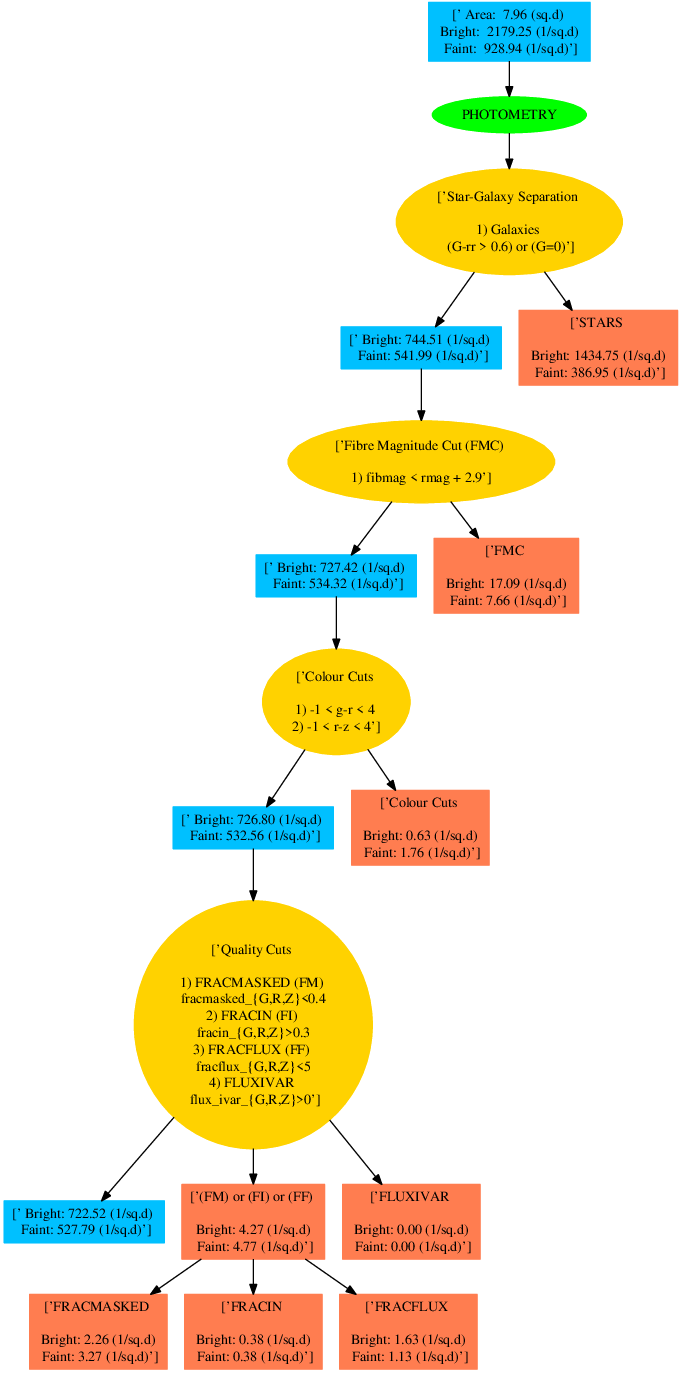

In [ ]:
flow = flow_2(file='%s/flow_2' %(dir_name), tPM=tPM, tSG=tSG, tFMC=tFMC, tCC=tCC, tQC=tQC, tQC_all=tQC_all, area=A)
flow

# MORE DEFINITIONS

## allmask Vs fracs* overlap in all stages...

In [3]:
def venn_stage(M, Mlab, A, PM=None, title=None, filename=None):
    
    from matplotlib_venn import venn2
    
    if PM is not None:
        a = (M[0]) & (~PM)
        b = (M[1]) & (~PM)
        c = (a) & (b)
    else:
        a = M[0]
        b = M[1]
        c = (a) & (b)
    
    sf = 2
    a1 = round((np.sum(a) - np.sum(c))/A, sf)
    b1 = round((np.sum(b) - np.sum(c))/A, sf)
    c1 = round(np.sum(c)/A, sf)

    plt.figure(figsize=(5, 5))
    plt.title('%s=%s' %('PM', title))
    venn2([a1, b1, c1], set_labels = (Mlab[0], Mlab[1]))
    
    if filename is not None:
            plt.savefig(filename+'.png')
    
    return np.sum(a)/A, np.sum(b)/A, np.sum(c)/A, a1, b1

In [4]:
def venn_stages(M, Mlab, A, PM, title, dir_name):
    data = []

    for i in range(len(stages)):
    
        a, b, c, a1, b1 = venn_stage(M=M, Mlab=Mlab, A=A, PM=(PM[i]), 
           title=title[i], filename='%s/venn_%s_%s_%s' %(dir_name, Mlab[0], Mlab[1], title[i]))
    
        data.append([title[i], a, b, c, a1, b1])
        
    data2 = []
    for i in range(len(data[0])):
        if len(data) == 6:
            data2.append([data[0][i], data[1][i], data[2][i], data[3][i] , data[4][i] , data[5][i]])
        if len(data) == 7:
            data2.append([data[0][i], data[1][i], data[2][i], data[3][i] , data[4][i] , data[5][i], data[6][i]])

    plt.figure(figsize=(10,5))
    plt.plot(data2[0], data2[1], marker='o', lw=2, label=Mlab[0])
    plt.xticks(rotation=90)
    plt.plot(data2[0], data2[2], marker='o', lw=2, label=Mlab[1])
    plt.plot(data2[0], data2[3], marker='o', lw=2, ls=r'--', alpha=0.4, label='%s & %s' %(Mlab[0], Mlab[1]))
    plt.plot(data2[0], data2[4], marker='o', lw=2, ls=r'--', alpha=0.8, label='%s & ~%s' %(Mlab[0], Mlab[1]))
    plt.plot(data2[0], data2[5], marker='o', lw=2, ls=r'--', alpha=0.8, label='~%s & %s' %(Mlab[0], Mlab[1]))

    plt.legend()
    plt.grid()
    plt.xlabel(r'PREVIOUS MASKING (PM)')
    plt.ylabel(r'1/deg$^2$')
    plt.savefig('%s/mask_density_%s_%s.png' %(dir_name, Mlab[0], Mlab[1]))
    plt.show()


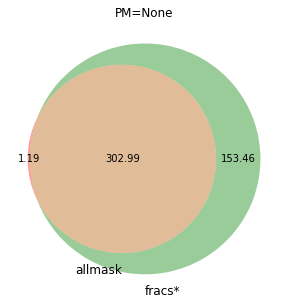

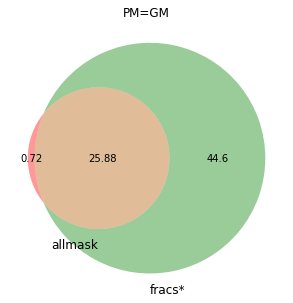

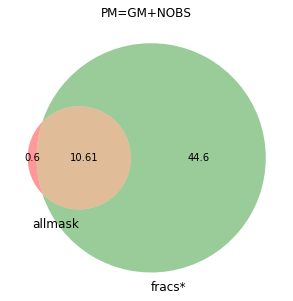

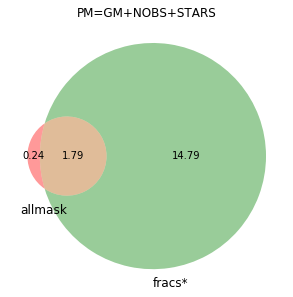

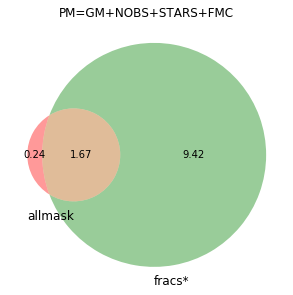

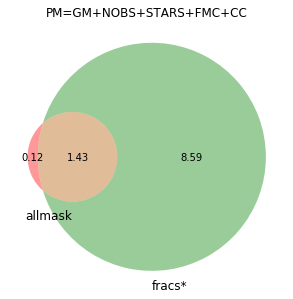

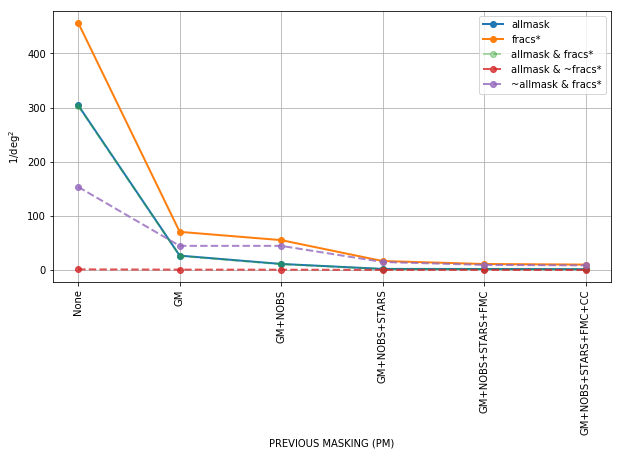

In [ ]:
stages = [None, (GMT), (GMT | nobs), (GMT | nobs | STARS), (GMT | nobs | STARS | ~FMC), (GMT | nobs | STARS | ~FMC | ~CC)]
stages_lab = ['None', 'GM', 'GM+NOBS', 'GM+NOBS+STARS', 'GM+NOBS+STARS+FMC', 'GM+NOBS+STARS+FMC+CC']
M = [allmask, ~QC]
Mlab=['allmask', 'fracs*']
venn_stages(M=M, Mlab=Mlab, A=A, PM=stages, title=stages_lab, dir_name=dir_name)

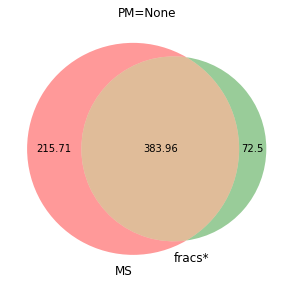

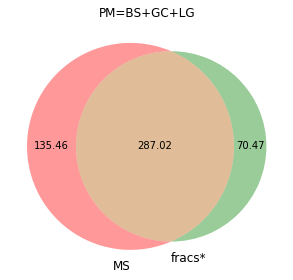

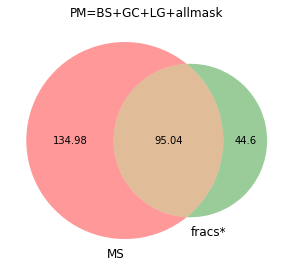

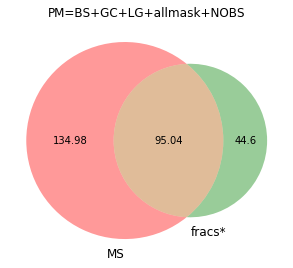

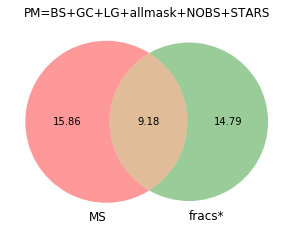

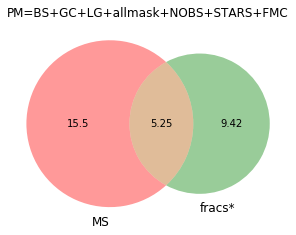

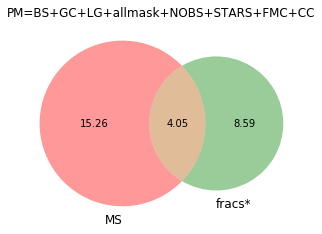

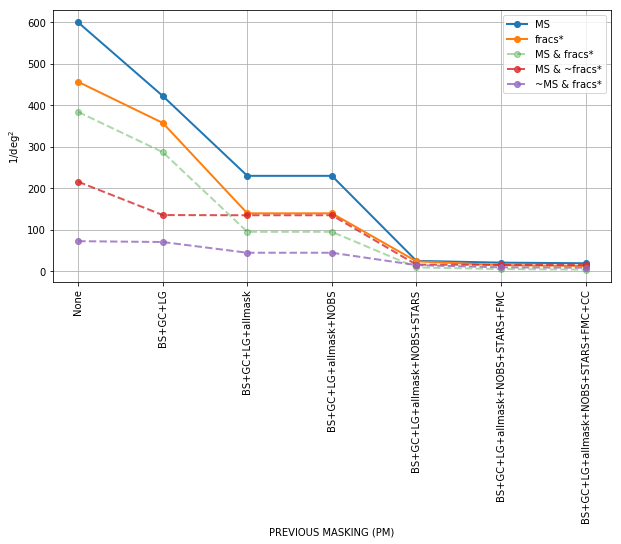

In [ ]:
stages = [None, (BS | GC | LG), (BS | GC | LG | allmask ), (BS | GC | LG | allmask | nobs), 
          (BS | GC | LG | allmask | nobs | STARS), (BS | GC | LG | allmask | nobs | STARS | ~FMC), 
          (BS | GC | LG | allmask | nobs | STARS | ~FMC | ~CC)]
stages_lab = ['None', 'BS+GC+LG', 'BS+GC+LG+allmask', 'BS+GC+LG+allmask+NOBS', 'BS+GC+LG+allmask+NOBS+STARS', 
              'BS+GC+LG+allmask+NOBS+STARS+FMC', 'BS+GC+LG+allmask+NOBS+STARS+FMC+CC']
M = [MS, ~QC]
Mlab=['MS', 'fracs*']
venn_stages(M=M, Mlab=Mlab, A=A, PM=stages, title=stages_lab, dir_name=dir_name)

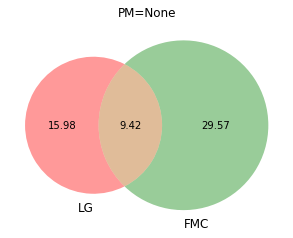

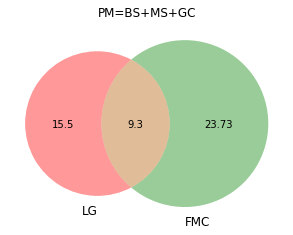

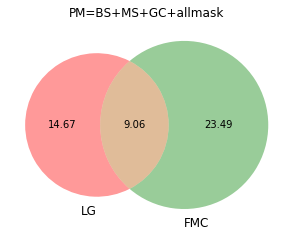

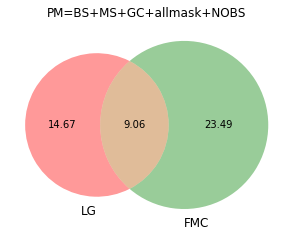

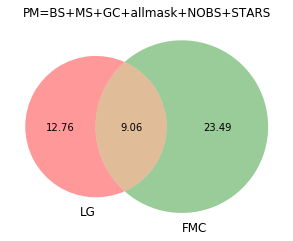

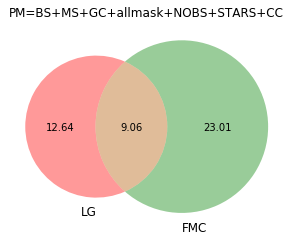

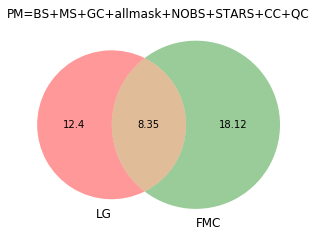

In [ ]:
stages = [None, (BS | MS | GC), (BS | MS | GC | allmask ), (BS | MS | GC | allmask | nobs), 
          (BS | MS | GC | allmask | nobs | STARS), (BS | MS | GC | allmask | nobs | STARS | ~CC), 
          (BS | MS | GC | allmask | nobs | STARS | ~CC | ~QC)]
stages_lab = ['None', 'BS+MS+GC', 'BS+MS+GC+allmask', 'BS+MS+GC+allmask+NOBS', 'BS+MS+GC+allmask+NOBS+STARS', 
              'BS+MS+GC+allmask+NOBS+STARS+CC', 'BS+MS+GC+allmask+NOBS+STARS+CC+QC']

M = [LG, ~FMC]
Mlab=['LG', 'FMC']
venn_stages(M=M, Mlab=Mlab, A=A, PM=stages, title=stages_lab, dir_name=dir_name)

## masking column...

In [ ]:
mask_lab = []
for i in range(len(nobs)):
    
    #lab = (GMT[i])*'1'+(nobs[i])*'2'+(allmask[i])*'3'+(STARS[i])*'4'+(~FMC[i])*'5'+(~CC[i])*'6'+(~QC[i])*'7'
    lab = (BS[i])*'0'+(MS[i])*'1'+(GC[i])*'2'+(LG[i])*'3'+(nobs[i])*'4'+(allmask[i])*'5'+(STARS[i])*'6'+(~FMC[i])*'7'+(~CC[i])*'8'+(~QC[i])*'9'
    mask_lab.append(lab) 

mask_lab = np.array(mask_lab)

In [ ]:
np.sum(MS)

## Save BGS catalogue...

In [ ]:
from astropy.table import Table

BGS = Table()
BGS_colnames = ['RA', 'DEC', 'TYPE', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_G', 
                'MW_TRANSMISSION_Z', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_DUPLICATED_SOURCE', 'FIBERFLUX_R', 'CUTS']


for i in BGS_colnames:
    if i is 'CUTS':
        BGS[i] = mask_lab
    else:
        BGS[i] = df[i]
        
BGS_cat_path = '%s/BGS_cat' %(dir_name)
np.save(BGS_cat_path, BGS)

## Postage images of allmask...

Via: http://faraday.uwyo.edu/~admyers/scratch/legacysurvey/output/dr8/bitmasks/#id3

    Bit 	Attribute 
    ---    ----------
    0 	detector bad pixel/no data
    1 	saturated
    2 	interpolated
    4 	single exposure cosmic ray
    6 	bleed trail
    7 	multi-exposure transient
    8 	edge
    9 	edge2
    11	outlier

In [41]:

badpix = ((df['ALLMASK_R'] & 2**0)!=0) | ((df['ALLMASK_G'] & 2**0)!=0) | ((df['ALLMASK_Z'] & 2**0)!=0)
satur = ((df['ALLMASK_R'] & 2**1)!=0) | ((df['ALLMASK_G'] & 2**1)!=0) | ((df['ALLMASK_Z'] & 2**1)!=0)
interp = ((df['ALLMASK_R'] & 2**2)!=0) | ((df['ALLMASK_G'] & 2**2)!=0) | ((df['ALLMASK_Z'] & 2**2)!=0)
cr = ((df['ALLMASK_R'] & 2**4)!=0) | ((df['ALLMASK_G'] & 2**4)!=0) | ((df['ALLMASK_Z'] & 2**4)!=0)
bleed = ((df['ALLMASK_R'] & 2**6)!=0) | ((df['ALLMASK_G'] & 2**6)!=0) | ((df['ALLMASK_Z'] & 2**6)!=0)
trans = ((df['ALLMASK_R'] & 2**7)!=0) | ((df['ALLMASK_G'] & 2**7)!=0) | ((df['ALLMASK_Z'] & 2**7)!=0)
edge = ((df['ALLMASK_R'] & 2**8)!=0) | ((df['ALLMASK_G'] & 2**8)!=0) | ((df['ALLMASK_Z'] & 2**8)!=0)
edge2 = ((df['ALLMASK_R'] & 2**9)!=0) | ((df['ALLMASK_G'] & 2**9)!=0) | ((df['ALLMASK_Z'] & 2**9)!=0)
outlier = ((df['ALLMASK_R'] & 2**11)!=0) | ((df['ALLMASK_G'] & 2**11)!=0) | ((df['ALLMASK_Z'] & 2**11)!=0)

allmask_bits = (badpix) | (satur) | (interp) | (cr) | (bleed) | (trans) | (edge) | (edge2) | (outlier)
print(np.sum(allmask_bits), np.sum(allmask))

2535 2551


In [42]:
#
am_bits = {'badpix':badpix, 'satur':satur, 'interp':interp, 'cr':cr, 'bleed':bleed, 'trans':trans, 
           'edge':edge, 'edge2':edge2, 'outlier':outlier}

def bit_alone(bit, bits_list, info=False):
    data = np.ones(len(bits_list[bit]), dtype='?')
    
    for i in bits_list:
        if info:
            print(i,':',np.sum(bits_list[i]))
        if i is bit:
            print(i,':',np.sum(bits_list[i]))
            data &= bits_list[i]
        else:
            data &= ~bits_list[i]
    print('%s alone: %i' %(bit, np.sum(data)))
    return data

dat = bit_alone(bit='badpix', bits_list=am_bits, info=True)

badpix : 62
badpix : 62
satur : 2396
interp : 0
cr : 0
bleed : 55
trans : 0
edge : 0
edge2 : 0
outlier : 57
badpix alone: 37


In [5]:
def merge_images(img_list, savefile, x_offset):
    
    import sys
    from PIL import Image
    
    images = [ Image.open(i) for i in img_list ]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
        
    new_im = Image.new('RGB', (total_width+(len(img_list)-1)*x_offset, max_height), color='white')

    j = 0
    for im in images:
        if j == 0:
            new_im.paste(im, (0,0))
            x_offset += im.size[0]
        else:
            new_im.paste(im, (x_offset,0))
            x_offset += x_offset
        j += 1

    new_im.save(savefile+'.png')

In [6]:
from astropy.utils.data import download_file  #import file from URL
from matplotlib.ticker import NullFormatter

def make_cutout_table(ra_in, dec_in, other=None, other2=None, other3=None, other4=None, othername=None, othername2=None, 
                      othername3=None, othername4=None, table=(2,7), compare=False,
                      scale_unit='pixscale', boxsize=30, scale=0.262, layer='decals-dr7', 
                      layer2=None, savefile=None, other_cat=None, Title=None, show=False, info=None):
    """
    Produces a table comparing LEGACY survey images.
    To see the different layers see: https://github.com/yymao/decals-image-list-tool/blob/master/index.html

    Keyword arguments:
    ra_in            -- array-like: RA positions in degrees
    dec_in           -- array-like: DEC positions in degrees
    other            -- array-like: any other parameter, e.g. magnitude
    othername        -- string: name or label of the 'other' parameter
    table            -- 2D integer array: arrange of the output images in (rows * columns) form
    compare          -- boolean: True if want to get output images comparing with other layer (currently in test mode)
    scale_unit       -- string: pixel scale default
    boxsize          -- integer, float: Size of the image in arc seconds
    scale            -- float: arc seconds per pixel. Default is 0.262
    layer            -- string: type of layer from legacysurvey. e.g:
                            ls-dr67:Legacy Survey DR6+7
                            decals-dr7:DECaLS DR7
                            decals-dr7-model:DECaLS DR7 Model
                            decals-dr7-resid:DECaLS DR7 Residual
                            mzls+bass-dr6:MzLS+BASS DR6
                            mzls+bass-dr6-model:MzLS+BASS DR6 Model
                            mzls+bass-dr6-resid:MzLS+BASS DR6 Residual
    layer2            -- string: second layer to compare if 'compare=True'
    savefile          -- string: path of output image and pdf if any
    other_cat         -- array-like: mark other catalogue sky positions around main catalogue objects (ra_in, dec_in)
    """
    de_img = []
    wi_img = []
    N = table[0]*table[1]
    size = int(round(boxsize/scale))
    print('pixels:',size)
    
    if other_cat != None:
        selects = []
        for i in range(len(ra_in)):
            
            delta = -3.
            MASK = np.ones_like(other_cat, dtype='?')
            MASK &= np.logical_and(other_cat['RA'] < ra_in[i]+(boxsize/2+delta)/3600, other_cat['RA'] > ra_in[i]-(boxsize/2+delta)/3600)
            MASK &= np.logical_and(other_cat['DEC'] < dec_in[i]+(boxsize/2+delta)/3600, other_cat['DEC'] > dec_in[i]-(boxsize/2+delta)/3600)
            for j in range(len(other_cat['RA'][MASK])):
                index = list(other_cat['RA']).index(other_cat['RA'][MASK][j])
                ra_pix = size/2 + (ra_in[i]-other_cat['RA'][MASK][j])*3600/scale
                dec_pix = size/2 + (dec_in[i]-other_cat['DEC'][MASK][j])*3600/scale
                
                selects.append([i, other_cat['RA'][MASK][j], other_cat['DEC'][MASK][j], ra_pix, dec_pix, ra_in[i], dec_in[i], 
                                other[i], bool(lowq[index]), bool(bgs_aqc[index]), bool(BRIGHT[index]), bool(FAINT[index]) ])
                
        selects = np.array(selects).transpose()
        print('A total of %i objects were found within the %i" boxsize of the %i postages' %(len(selects[0]), boxsize, len(ra_in)))
        print('Of which...')
        print('good = %i' %(np.sum(selects[9])))
        print('bad = %i' %(np.sum(selects[8])))
        print('bright = %i' %(np.sum(selects[10])))
        print('faint = %i' %(np.sum(selects[11])))


    if isinstance(ra_in, float):
        de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%.12f&dec=%.12f&%s=%g&layer=%s&size=%g' % (ra_in,dec_in, scale_unit, scale, layer, size)
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        fig = plt.figure(figsize=(10,10))
        
        if other != None:
            plt.text(0.1,0.9,'%s=%.1f'%(othername,other),fontsize=14,color='white')

        return

    for i in range(N):
        de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%.12f&dec=%.12f&%s=%g&layer=%s&size=%g' % (ra_in[i],dec_in[i], scale_unit, scale, layer, size)
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)

        if compare:
            wi_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%g&dec=%g&%s=%g&layer=%s&size=%g' % (ra_in[i],dec_in[i], scale_unit, scale, layer2, size)
            img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
            wi_img.append(img)

    fig = plt.figure(figsize=(4*table[1],4*table[0]))
    if N <= 30:
        y1 = 0.96
        fs = 15
    else:
        y1 = 0.92
        fs = 25
        
    fig.suptitle(Title+'\n samp. cat.: %s \n samp. size: %2.3g %%' %(info[0], info[1]), y=y1, fontsize=fs)
    
    scale_l = np.array([[size*5/8, size*7/8], [size*1/8, size*1/8]])

    for i in range(len(de_img)):
        ax = fig.add_subplot(table[0],table[1],i+1)
        ax.imshow(de_img[i], origin='lower', aspect='equal')
        ax.axvline(size/2, lw=1, color='white')
        ax.axhline(size/2, lw=1, color='white')
        ax.plot(scale_l[0], scale_l[1], lw=2, color='white')
        ax.text(size*5.7/8, size*1.3/8, '%i" ' %(boxsize/4), color='yellow')
        #ax.grid()
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        if other_cat != None:
            mask = selects[0] == i
            plt.scatter(selects[3][(mask) & (selects[9] == 1) & (selects[10] == 1)], selects[4][(mask) & (selects[9] == 1) & (selects[10] == 1)], s = 120, facecolors='none', edgecolors='lime', lw=2)
            plt.scatter(selects[3][(mask) & (selects[9] == 1) & (selects[11] == 1)], selects[4][(mask) & (selects[9] == 1) & (selects[11] == 1)],s = 120, marker='s',facecolors='none', edgecolors='lime', lw=2)
            plt.scatter(selects[3][(mask) & (selects[8] == 1) & (selects[10] == 1)], selects[4][(mask) & (selects[8] == 1) & (selects[10] == 1)], s = 120, facecolors='none', edgecolors='red', lw=2)
            plt.scatter(selects[3][(mask) & (selects[8] == 1) & (selects[11] == 1)], selects[4][(mask) & (selects[8] == 1) & (selects[11] == 1)],s = 120, marker='s', facecolors='none', edgecolors='red', lw=2)
            
        if other[i] != None:
            ax.text(0.1,0.9,'%s=%.3f'%(othername,other[i]),transform=ax.transAxes,fontsize=8,color='white')
            ax.set_title(r'RA=%.5f, DEC=%.5f' %(ra_in[i], dec_in[i]), size=9)
            ax.text(0.1,0.85,'%s'%(other2[i]),transform=ax.transAxes,fontsize=8,color='yellow')
            ax.text(0.1,0.8,'%s=%s'%(othername3,other3[i]),transform=ax.transAxes,fontsize=8,color='yellow')
            ax.text(0.1,0.75,'%s=%.3f'%(othername4,other4[i]),transform=ax.transAxes,fontsize=8,color='yellow')

    plt.subplots_adjust(wspace=0.02, hspace=0.09)
    

    if compare:
        fig = plt.figure(figsize=(4*table[1],4*table[0]))
        for i in range(len(wi_img)):
            ax = fig.add_subplot(table[0],table[1],i+1)
            ax.imshow(wi_img[i])
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            if other[i] != None:
                ax.text(0.1,0.9,'%s=%.1f'%(othername,other[i]),transform=ax.transAxes,fontsize=14,color='white')

        #plt.subplots_adjust(wspace=0.07, hspace=0.07)

    if savefile != None:
        fig.savefig(savefile +'.png', bbox_inches = 'tight', pad_inches = 0)
        #fig.savefig(savefile +'.pdf')
    if not show:
        plt.close()
        

In [7]:
def get_postages(CAT, N, M,  par2, par2name, boxsize=30, get_coord=False, selection='rand',  savefile=None, 
                 other_cat=None, merge=False, show=False, get_coordFile=False, info=None):
    '''
    Get postage images tables with sizes NXM.
    inputs
    -------
    CAT: (array) Catalogue
    N: (integer) Number of rows
    M: (integer) Number of columns
    
    outputs
    -------
    Table of size NXM of postage images froma random sample of catalogue
    
    '''
    
    import random
    
    table = (N,M)
    
    rMag = flux_to_mag(CAT['FLUX_R']/CAT['MW_TRANSMISSION_R'])
    RA, DEC = CAT['RA'], CAT['DEC']
    Type = CAT['TYPE']
    if par2 is not None:
        frac = par2
    samsize = (N*M*100)/(len(CAT))
    print('Sample Size: %2.3g' %(samsize))
    if info is not None:
        info = [info, samsize]
    fibermag = flux_to_mag(CAT['FIBERFLUX_R']/CAT['MW_TRANSMISSION_R'])

    if selection == 'random':
        ranSelect = random.sample(range(len(RA)), N*M)
    elif selection == 'sorted':
        ranSelect = np.zeros(N*M,dtype=np.int32)
        N = np.linspace(rMag.min(), rMag.max(), N*M+1)
        for i in range(len(N)-1):
            binsize = (N[i+1]-N[i])
            maskt = np.logical_and(rMag > N[i] + binsize/2 - binsize/2, rMag < N[i] + binsize/2 + binsize/2)
            if np.sum(maskt) == 0:
                sys.exit('Error! There is none objects whitin bin %2.5g < r-mag < %2.5g' %(N[i], N[i] + binsize))
            ranindex = random.sample(range(len(rMag[maskt])), 1)
            X = list(rMag).index(rMag[maskt][ranindex])
            ranSelect[i] = X
    elif selection == 'fixed':
        MASK = np.ones_like(RA, dtype='?')
        N = np.linspace(0, len(RA)-1, N*M, dtype=np.int32)
        MASK[N] = False
        ranSelect = ~MASK
    
    make_cutout_table(RA[ranSelect], DEC[ranSelect], rMag[ranSelect], Type[ranSelect], frac[ranSelect], 
                      fibermag[ranSelect], 'r', None, par2name, 'fibMag',
                      table, False, boxsize=boxsize, layer='dr8c-decam', layer2=None,  savefile=savefile+'_images', 
                      other_cat=other_cat, Title='IMAGES', show=show, info=info)


    make_cutout_table(RA[ranSelect], DEC[ranSelect], rMag[ranSelect], Type[ranSelect], frac[ranSelect], 
                      fibermag[ranSelect], 'r', None, par2name, 'fibMag',
                      table, False, boxsize=boxsize, layer='dr8c-decam-model', layer2=None, savefile=savefile+'_models', 
                          Title='MODELS', show=show, info=info)
    
    #========== merge images side by side ============
    if merge:
    
        images_list = [savefile+'_images'+'.png', savefile+'_models'+'.png']
        merge_images(images_list, savefile, x_offset=70)
        
    if get_coord:
        return np.array([RA[ranSelect], DEC[ranSelect]])

In [44]:

for i in ['badpix', 'satur', 'bleed', 'outlier']:
    
    dat = bit_alone(bit=i, bits_list=am_bits)
    mask = (dat) #& (~STARS)
    postages_path = dir_name+'/allmask_bits_postages'
    os.system('mkdir %s' %(postages_path))
    #print(np.sum(mask))
    
    get_postages(df[mask], 5,4, par2=mask_lab[mask], par2name='MK', boxsize=30, selection='random', 
             savefile='%s/%s_only' %(postages_path, i), 
             other_cat=None, merge=True, show=False, get_coordFile=False, info='(%s_only)' %(i))


badpix : 62
badpix alone: 37
Sample Size: 54.1
pixels: 115
pixels: 115
satur : 2396
satur alone: 2361
Sample Size: 0.847
pixels: 115
pixels: 115
bleed : 55
bleed alone: 49
Sample Size: 40.8
pixels: 115
pixels: 115
outlier : 57
outlier alone: 53
Sample Size: 37.7
pixels: 115
pixels: 115


In [46]:
BGS_mask_list = {'BS':BS, 'MS':MS, 'GC':GC, 'LG':LG, 'allmask':allmask, 'nobs':nobs, 'STARS':STARS, 'FMC':~FMC, 'CC':~CC, 'QC':~QC}
dat = bit_alone(bit='QC', bits_list=BGS_mask_list, info=True)

BS : 1485
MS : 5029
GC : 0
LG : 213
allmask : 2551
nobs : 157
STARS : 19249
FMC : 327
CC : 331
QC : 3828
QC : 3828
QC alone: 72


In [58]:
#for i in ['MS', 'QC', 'FMC']:
for i in ['MS']:
    
    dat = bit_alone(bit=i, bits_list=BGS_mask_list)
    mask = (dat)
    postages_path = dir_name+'/BGS_mask_postages'
    os.system('mkdir %s' %(postages_path))
    #print(np.sum(mask))
    
    get_postages(df[mask], 5,6, par2=mask_lab[mask], par2name='MK', boxsize=20, selection='random', 
             savefile='%s/%s_only' %(postages_path, i), 
             other_cat=None, merge=True, show=False, get_coordFile=False, info='(%s_only)' %(i))


MS : 5029
MS alone: 128
Sample Size: 23.4
pixels: 76
pixels: 76


# DEV ZONE...


In [ ]:
BGS_mask_list = {'BS':BS, 'MS':MS, 'GC':GC, 'LG':LG, 'allmask':allmask, 'nobs':nobs, 'STARS':STARS, 
                 'FMC':~FMC, 'CC':~CC, 'QC':~QC}
test = bit_alone(bit='QC', bits_list=BGS_mask_list, info=True)

In [59]:
mask_lab


array(['', '137', '1347', ..., '4', '4', '4'], dtype='<U6')

In [ ]:
lab = (GMT[i])*'1'+(nobs[i])*'2'+(allmask[i])*'3'+(STARS[i])*'4'+(~FMC[i])*'5'+(~CC[i])*'6'+(~QC[i])*'7'